In [1]:
import dask
import pystac_client
import planetary_computer as pc
import stackstac
import dask.array as da
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()

client = Client(cluster)
client

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46127 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/makhtar@clarku.edu/proxy/46127/status,
Dashboard: /user/makhtar@clarku.edu/proxy/46127/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42977,Workers: 4
Dashboard: /user/makhtar@clarku.edu/proxy/46127/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:35633,Total threads: 2
Dashboard: /user/makhtar@clarku.edu/proxy/36733/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:41275,


In [3]:
# collection for the required geometry
bbox = (35.16402630997399, 11.240162235950265, 35.17440912681519, 11.249823496541282)


In [4]:
catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=["2017-01-01", "2022-12-31"],
    query={"eo:cloud_cover": {"lt": 50}}

)

In [5]:
items = search.item_collection()
len(items)

354

In [6]:
%%time
items = pc.sign(search)
len(items)

CPU times: user 1.04 s, sys: 25 ms, total: 1.06 s
Wall time: 1.04 s


354

In [7]:
%%time
stack = stackstac.stack(items, bounds_latlon=bbox, assets=["green", "nir", "scl"])
stack

CPU times: user 147 ms, sys: 9.83 ms, total: 157 ms
Wall time: 161 ms


/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-a3ba85b72da938b3ee8000aec635b2ed' (time: 354,
                                                                band: 3,
                                                                y: 109, x: 115)>
dask.array<fetch_raster_window, shape=(354, 3, 109, 115), dtype=float64, chunksize=(1, 1, 109, 115), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2017-01-05...
    id                                       (time) <U24 'S2A_36PYT_20170105_...
  * band                                     (band) <U5 'green' 'nir' 'scl'
  * x                                        (x) float64 7.362e+05 ... 7.374e+05
  * y                                        (y) float64 1.244e+06 ... 1.243e+06
    earthsearch:payload_id                   (time) <U74 'roda-sentinel2/work...
    ...                                       ...
    title                                    (band) <U30 'Green (band 3) - 10...
    raster:bands                             (band) object None ... [{'nodata...
    common_name                              (band) object 'green' 'nir' None
    center_wavelength                        (band) object 0.56 0.842 None
    full_width_half_max                      (band) object 0.045 0.145 None
    epsg                                     int64 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(736250.0, 1243400.0, 737400.0...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 736250.00|\n| 0.00,-10.00, 1244490.00|\n| 0.0...
    resolution:  10.0

In [8]:
stack.band

<xarray.DataArray 'band' (band: 3)>
array(['green', 'nir', 'scl'], dtype='<U5')
Coordinates: (12/19)
  * band                                     (band) <U5 'green' 'nir' 'scl'
    proj:epsg                                int64 32636
    constellation                            <U10 'sentinel-2'
    mgrs:latitude_band                       <U1 'P'
    s2:saturated_defective_pixel_percentage  int64 0
    s2:product_type                          <U7 'S2MSI2A'
    ...                                       ...
    title                                    (band) <U30 'Green (band 3) - 10...
    raster:bands                             (band) object None ... [{'nodata...
    common_name                              (band) object 'green' 'nir' None
    center_wavelength                        (band) object 0.56 0.842 None
    full_width_half_max                      (band) object 0.045 0.145 None
    epsg                                     int64 32636

In [9]:
stack = stack.assign_coords(band=stack.common_name.fillna(stack.band).rename("band"))
stack.band

<xarray.DataArray 'band' (band: 3)>
array(['green', 'nir', 'scl'], dtype=object)
Coordinates: (12/19)
  * band                                     (band) object 'green' 'nir' 'scl'
    proj:epsg                                int64 32636
    constellation                            <U10 'sentinel-2'
    mgrs:latitude_band                       <U1 'P'
    s2:saturated_defective_pixel_percentage  int64 0
    s2:product_type                          <U7 'S2MSI2A'
    ...                                       ...
    title                                    (band) <U30 'Green (band 3) - 10...
    raster:bands                             (band) object None ... [{'nodata...
    common_name                              (band) object 'green' 'nir' None
    center_wavelength                        (band) object 0.56 0.842 None
    full_width_half_max                      (band) object 0.045 0.145 None
    epsg                                     int64 32636

In [10]:
green = stack.sel(band="green")
nir = stack.sel(band="nir")
green
nir

<xarray.DataArray 'stackstac-a3ba85b72da938b3ee8000aec635b2ed' (time: 354,
                                                                y: 109, x: 115)>
dask.array<getitem, shape=(354, 109, 115), dtype=float64, chunksize=(1, 109, 115), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2017-01-05...
    id                                       (time) <U24 'S2A_36PYT_20170105_...
    band                                     <U3 'nir'
  * x                                        (x) float64 7.362e+05 ... 7.374e+05
  * y                                        (y) float64 1.244e+06 ... 1.243e+06
    earthsearch:payload_id                   (time) <U74 'roda-sentinel2/work...
    ...                                       ...
    title                                    <U30 'NIR 1 (band 8) - 10m'
    raster:bands                             object None
    common_name                              object 'nir'
    center_wavelength                        object 0.842
    full_width_half_max                      object 0.145
    epsg                                     int64 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(736250.0, 1243400.0, 737400.0...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 736250.00|\n| 0.00,-10.00, 1244490.00|\n| 0.0...
    resolution:  10.0

In [11]:
scl_values = [3, 8, 9, 10] 
sclmask = 0
for field in scl_values:
    sclmask |= 1 << field

bin(sclmask)

'0b11100001000'

In [12]:
qa = stack.sel(band="scl").astype("uint16")
bad = qa & sclmask  

good = stack.where(bad == 0) 

In [13]:
def ndwi(green, nir):
    return (green - nir) / (green + nir)
filtered_green = good.sel(band="green")
filtered_nir = good.sel(band="nir")

ndwi_stack = ndwi(filtered_green, filtered_nir)


In [13]:
ndwi_stack

<xarray.DataArray 'stackstac-31f6f0ca77f3cb9ca0c7dee07b3df9ea' (time: 349,
                                                                y: 109, x: 115)>
dask.array<truediv, shape=(349, 109, 115), dtype=float64, chunksize=(1, 109, 115), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2017-01-05...
    id                                       (time) <U24 'S2A_36PYT_20170105_...
  * x                                        (x) float64 7.362e+05 ... 7.374e+05
  * y                                        (y) float64 1.244e+06 ... 1.243e+06
    s2:datatake_type                         <U8 'INS-NOBS'
    s2:processing_baseline                   (time) <U5 '00.01' ... '05.09'
    ...                                       ...
    s2:datatake_id                           (time) <U34 'GS2A_20170105T08031...
    instruments                              <U3 'msi'
    s2:reflectance_conversion_factor         (time) float64 1.034 ... 1.034
    earthsearch:s3_path                      (time) <U80 's3://sentinel-cogs/...
    s2:mgrs_tile                             (time) object None None ... None
    epsg                                     int64 32636

In [14]:
mean_ndwi = ndwi_stack.mean(dim=["x", "y"])
mean_ndwi

<xarray.DataArray 'stackstac-a3ba85b72da938b3ee8000aec635b2ed' (time: 354)>
dask.array<mean_agg-aggregate, shape=(354,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2017-01-05...
    id                                       (time) <U24 'S2A_36PYT_20170105_...
    earthsearch:payload_id                   (time) <U74 'roda-sentinel2/work...
    processing:software                      (time) object {'sentinel2-to-sta...
    s2:not_vegetated_percentage              (time) float64 93.5 93.16 ... 52.63
    s2:high_proba_clouds_percentage          (time) object 8.6e-05 ... 5.797588
    ...                                       ...
    s2:cloud_shadow_percentage               (time) object 0 0 0 ... 0 0 8.62381
    s2:datatake_id                           (time) <U34 'GS2A_20170105T08031...
    s2:datatake_type                         <U8 'INS-NOBS'
    s2:vegetation_percentage                 (time) float64 3.588 ... 13.05
    s2:mgrs_tile                             (time) object None None ... None
    epsg                                     int64 32636

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(-1.0, 1.0)

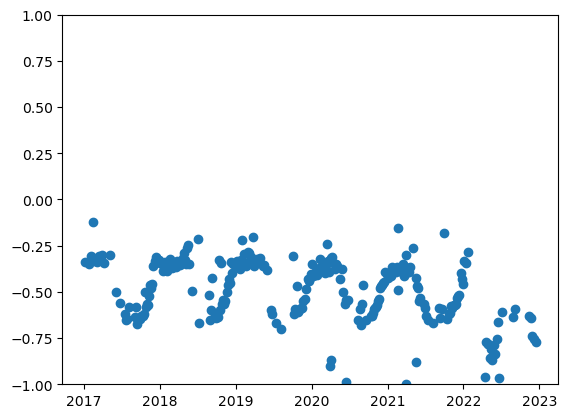

In [15]:
fig,ax = plt.subplots()
ax.scatter(x=mean_ndwi.time, y=mean_ndwi)
ax.set_ylim(-1,1)